# [0] REPRODUCIBILITY AND ENVIRONMENT 

In [55]:
import numpy as np, random, os 
RANDOM_STATE = 42 
np.random.seed(RANDOM_STATE) # Setting Numpy's global pseudo-random number generator seed 
random.seed(RANDOM_STATE) # Setting Python's built-in RNG seed 
os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE) # Fixing Python's hash randomisation seed 
print("Random seed set as:", RANDOM_STATE)


Random seed set as: 42


# [1] DATA LOADING AND INITIAL INSPECTION 

## [1A] Loading the Dataset: 

In [24]:
import pandas as pd

# Loading the dataset:
data_path = "C:\\Users\\Sonia Varghese\\workspace\\breast-cancer-wbc-ml\\data\\breast-cancer.csv"
df = pd.read_csv(data_path)

# Obtaining the description of the dataset:
print(df.shape) 
print(df.info())

(683, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Sample code number           683 non-null    int64
 1   Clump Thickness              683 non-null    int64
 2   Uniformity of Cell Size      683 non-null    int64
 3   Uniformity of Cell Shape     683 non-null    int64
 4   Marginal Adhesion            683 non-null    int64
 5   Single Epithelial Cell Size  683 non-null    int64
 6   Bare Nuclei                  683 non-null    int64
 7   Bland Chromatin              683 non-null    int64
 8   Normal Nucleoli              683 non-null    int64
 9   Mitoses                      683 non-null    int64
 10  Class                        683 non-null    int64
dtypes: int64(11)
memory usage: 58.8 KB
None


### Notes: 

- The dataset has 683 rows (samples) and 11 columns (features). The entries are indexed from 0 to 682.
- All columns have 683 non-null entries, indicating there are no missing values in the dataset.
- All columns are of type int64, meaning they contain integer values.
- The 'Class' column is the target variable, which the machine learning models aim to predict.

## [1B] Initial Inspection of the Dataset: 

In [25]:
df.head(5)

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


### Note: 

The 11 columns of this curated dataset have been explained in detail in the doc titled ['About the Dataset'](..\\docs\\about-dataset.md). 

## [1C] Visualising the Class Distribution: 

Class
2    444
4    239
Name: count, dtype: int64


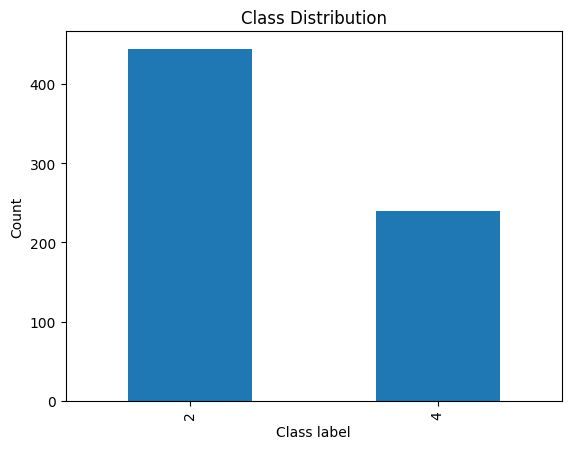

In [26]:
import matplotlib.pyplot as plt 
target_col = "Class" # 2=benign, 4=malignant in this dataset 

# To check for class imbalance: 
class_counts = df[target_col].value_counts().sort_index() 
print(class_counts) 

# Plotting the figure: 
plt.figure()
class_counts.plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Class label")
plt.ylabel("Count")
plt.show() 

### Notes: 

- There are 444 benign and 239 malignant breast cancer cases in this dataset. 
- In classification predictive modeling, we predict a class label for a given observation.
- However, when the distribution of examples is biased or skewed across the known classes, the classification problem is said to be **imbalanced**. 
- In this dataset, there seems to be a slight imbalance. 

# [2] DATA PRE-PROCESSING 

## [2A] Check for Missing Values: 

In [27]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Sample code number             0
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64


### Notes: 

- Each feature column and the target variable column (Class) have a complete set of entries, that is, all
columns have 683 non-null entries.
- This confirms that the dataset has no missing values.
- Therefore, we do not need to apply any imputation methods. We can move on to the next step.

## [2B] Checking for Correlation: 

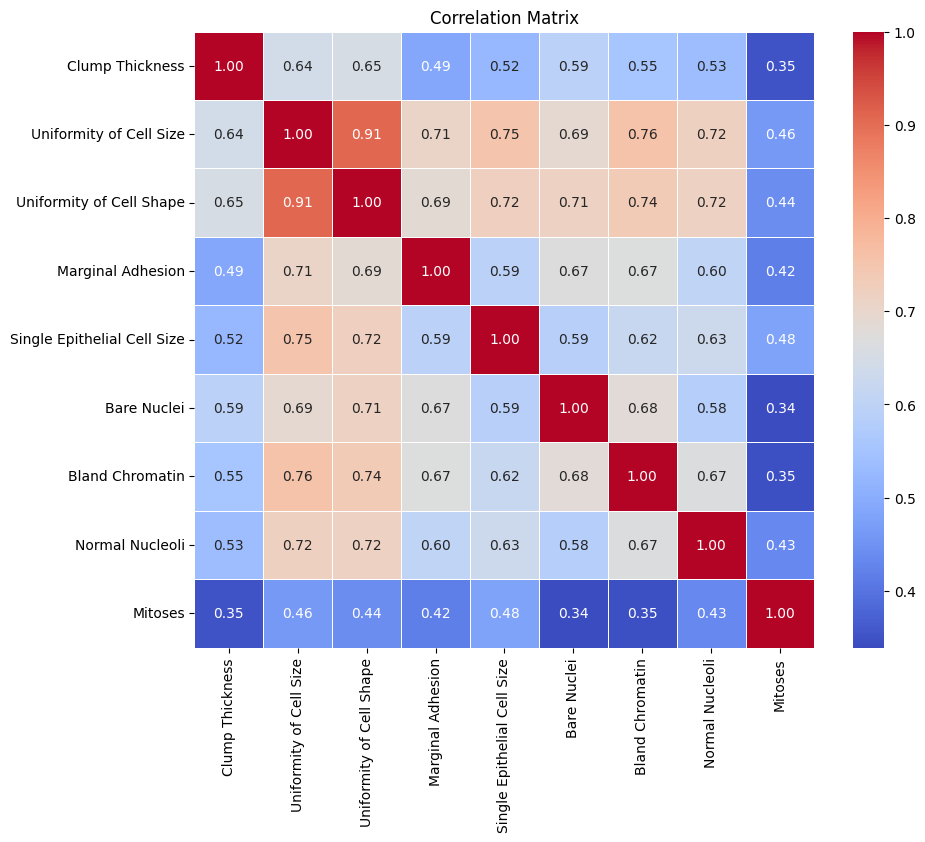

In [36]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

# Removing irrelevant columns and retaining only the feature columns of the dataset: 
id_col = "Sample code number"
target_col = "Class"
feature_cols = [c for c in df.columns if c not in (id_col, target_col)]
X = df[feature_cols]
y = df[target_col] # Labels 

# Creating the correlation matrix and plotting the corresponding heatmap: 
correlation_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [29]:
# Identifying the highly correlated feature pairs (>= 0.9): 
threshold = 0.9
highly_correlated_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) >= threshold:
            feature_pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            highly_correlated_pairs.append(feature_pair)

print("Highly correlated feature pairs (where correlation coefficient >= 0.9):")
for pair in highly_correlated_pairs:
    print(pair)

Highly correlated feature pairs (where correlation coefficient >= 0.9):
('Uniformity of Cell Shape', 'Uniformity of Cell Size')


### Notes: 

- Correlation is present if there is a value of 0.9 and more.
- From the above result, we can conclude that the features 'Uniformity of Cell Shape' and 'Uniformity of
Cell Size' are highly correlated.

## [2C] Mitigating Correlation: 

### Available Mitigation Measures and Their Pros and Cons: 

1. **Dropping a Feature:**
   - **Pros:**
     - **Simplicity:** This approach is straightforward and easy to implement.
     - **Interpretability:** The remaining features are easier to interpret since they remain in their original form. 
     - **Efficiency:** Reduces the dimensionality of the dataset, which can improve computational efficiency.
   - **Cons:**
     - **Loss of Information:** We might lose valuable information contained in the dropped feature. 
     - **Arbitrary Choice:** Deciding which feature to drop can be arbitrary and might require domain knowledge.
   - **When to Use:**
     - When the correlation is very high, and the features are almost identical in terms of the information they provide. 
     - When interpretability of the model is crucial. 
     - When we have relevant domain knowledge suggesting one feature is more relevant than the other.

2. **Combining Features (Example: Using PCA):**
   - **Pros:**
     - **Retains Information:** Combines the information from correlated features, reducing the loss of information. 
     - **Handles Multicollinearity:** Effectively addresses multicollinearity by transforming correlated features into uncorrelated components.
     - **Dimensionality Reduction:** PCA can reduce the number of features while retaining most of the variance in the data.
   - **Cons:**
     - **Interpretability:** The principal components are linear combinations of the original features, which can make interpretation more difficult.
     - **Complexity:** Requires additional steps to implement and might require tuning the number of components. 
   - **When to Use:**
     - When we want to retain as much information as possible. 
     - When we are dealing with datasets with many correlated features.
     - When our primary goal is prediction accuracy rather than interpretability.

### What mitigation measure would work best for this dataset?

For this dataset, I am choosing to drop one of the features (**Uniformity of Cell Size**) rather than applying Principal Component Analysis (PCA), for the following reasons:

1. **Preserving Interpretability**
   - PCA transforms features into **linear combinations** called principal components, which are mathematically useful but **not directly interpretable**. 
   - In medical and life science applications, we often need to **trace model decisions back to individual clinical features**. 
   - Dropping one redundant feature lets us keep the remaining feature **intact and meaningful**, which is critical when comparing with scientific literature.

2. **Alignment with Medical Literature**
   - The project explicitly requires compare feature importances with findings from scientific literature. 
   - PCA components are abstract and **do not map cleanly** to original features, making such comparison difficult or even impossible.
   - By **dropping Uniformity of Cell Size** (less frequently cited) and keeping **Uniformity of Cell Shape** (well-supported in literature), a feature set is maintained that can be biologically interpreted and validated.
  
3. **Simplicity and Transparency**
   - Dropping a feature is a **simple and transparent** method to mitigate multicollinearity. 
   - PCA introduces extra complexity such as the number of components to keep, explained variance trade-offs, and the need to inverse-transform features for interpretability. 
   - In this project, the number of features is small (10), so dropping 1 or 2 redundant ones is **efficient and sufficient**.

4. **Avoiding Loss of Performance in Tree-based Models**
   - Tree-based models (like Random Forest or Gradient Boosting) **do not require feature scaling** and are relatively **robust to multicollinearity**. 
   - Applying PCA in such models often **adds unnecessary preprocessing** and can even reduce performance by obscuring meaningful feature splits.

In [37]:
# Applying the dropping-a-feature mitigation measure: 
to_drop = set() # To avoid having duplicates of features 
for a, b in highly_correlated_pairs: 
    if {a,b} == {"Uniformity of Cell Size", "Uniformity of Cell Shape"}: # Domain-aware feature-dropping method
        to_drop.add("Uniformity of Cell Size")
    else: # Default method where the second feature is dropped 
        to_drop.add(b) 

print("\nApplied drop-one measure; will drop:", sorted(to_drop)) 

# Dropping the columns and show shape change: 
X_reduced = X.drop(columns=list(to_drop))
print("Original shape (features only):", X.shape)
print("Reduced shape:", X_reduced.shape)
print("y shape:", y.shape)
print("Class distribution:\n", y.value_counts())


Applied drop-one measure; will drop: ['Uniformity of Cell Size']
Original shape (features only): (683, 9)
Reduced shape: (683, 8)
y shape: (683,)
Class distribution:
 Class
2    444
4    239
Name: count, dtype: int64


# [3] MODELLING, HYPERPARAMETER TUNING, & MODEL EVALUATION

## Notes on Model Evaluation: 

One of the main objectives of this project is to determine which machine learning algorithm (among kNN, Logistic regression, SVM, Decision Tree, Random Forest, AdaBoost, and GradientBoost) works best for the given curated dataset. The aforementioned algorithms are explained in more detail in the document titled ['About ML Algorithms'](..\\docs\\about-ml-algorithms.md). 

In **model evaluation**, the available dataset is used to fit a model and estimate its performance when making predictions on unseen examples. The two most common approaches used for model evaluation are the **train/test split** (could be 50/50, 60/40, etc) and the **k-fold cross-validation** procedure. These approaches are effective in general, but can fail when used on classification problems with a severe **class imbalance**. 

As previously shown, there are 444 benign and 239 malignant breast cancer cases in this dataset. That is roughly 65% benign vs 35% malignant. This is not an extreme imbalance like 95% vs 5%, but still imbalanced enough that naïve splits could create folds missing enough malignant cases, which would distort performance metrics. 

**Problem with plain train/test split:**
  - A random split might, by chance, allocate too few malignant cases to the test set. 
  - That makes F1 and AUROC unreliable, especially if the test set is small.

**Problem with k-fold CV:**
  - Similarly, if folds are chosen at random, some folds might contain skewed distributions of benign vs malignant. 
  - A model trained on a fold with very few malignant cases will perform poorly in an artificial way, not reflecting true performance.

**Solution:** 
To address these problems, **stratified train-test split or stratified k-fold cross-validation** is used instead, wherein the sampling is stratified by the class label. The following reasons support this choice: 
- Stratification ensures each fold preserves the class ratio (~65:35). 
- This means: 
  - Every training set and validation set contains a fair mix of benign and malignant. 
  - The model is evaluated on “balanced” mini versions of the full dataset.
- Thus, performance estimates are more stable and realistic, avoiding the “bad luck” of skewed splits.

## Notes on Hyperparameter Tuning: 

Machine learning models have **hyperparameters**, which are points of choice or configuration specified by the developer, that allow a machine learning model to be customised for a specific task or dataset. **Hyperparameter Optimisation/Tuning/Search** is the process of searching for a set of hyperparameters that result in the best performance of a model on a dataset. 

The two simplest and most common optimisation algorithms are: 
1. **Random Search:** Define a search space as a bounded domain of hyperparameter values and randomly sample points in that domain (Scikit-learn's RandomisedSearchCV). 
2. **Grid Search:** Define a search space as a grid of hyperparameter values and evaluate every position in the grid (Scikit-learn's GridSearchCV). 

For this project, the **Grid Search** method is chosen for the following reasons: 
- Different algorithms are sensitive to hyperparameters (e.g., k in kNN, C and gamma in SVMs, tree depth in Decision Trees). 
- Using only default values could make some models look worse simply because their defaults are not well-suited to this dataset. 
- GridSearchCV performs a systematic search over a small set of sensible hyperparameters and uses cross-validation to select the combination that maximises performance. 
- This guarantees that the comparison between models is fair, reproducible, and not biased by arbitrary default settings. 
- Since the dataset is relatively small, the computational cost of this tuning step is low, and the benefit in terms of reliable evaluation outweighs the extra complexity.

## Notes on Model Evaluation Metrics: 

The project requires the use of **F1 and AUCROC** as the model performance metrics. They have been explained in detail (along with other such metrics) in the document titled ['About Performance Metrics'](..\\docs\\about-performance-metrics.md). 

The F1 score (for malignant) directly penalises missing malignant cases. AUCROC gives a  threshold-independent view of separability. These two together provide a robust picture of model quality under class imbalance.

**Please note that the code blocks below (showing a robust pipeline detailing modelling, hyperparameter tuning, and model evaluation) were created with the help of OpenAI's ChatGPT (GPT-5).** 

In [31]:
# Importing the important stuff: 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler # For standardising features for LogReg, SVM, & kNN 
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate 
from sklearn.metrics import make_scorer, f1_score 

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier 

In [41]:
# CV setup + Scoring: 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = RANDOM_STATE)
scoring = {'f1': make_scorer(f1_score, pos_label=4), 'roc_auc': 'roc_auc'}

In [47]:
# Initialising the models and hyperparameter grids: 
models = {
    "kNN": (
        KNeighborsClassifier(),
        {'clf__n_neighbors':[3,5,7,9]}
    ), 
    "LogReg": (
        LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
        {'clf__C':[0.1,1,10], 'clf__penalty':['l2'], 'clf__class_weight':[None, 'balanced']}
    ),
    "SVM": (
        SVC(probability=True, random_state=RANDOM_STATE),
        {'clf__C':[0.1,1,10], 'clf__kernel':['rbf'], 'clf__gamma':['scale','auto'], 'clf__class_weight':[None, 'balanced']}
    ), 
    "DT": (
        DecisionTreeClassifier(random_state = RANDOM_STATE), 
        {'clf__max_depth':[None,3,5,7], 'clf__min_samples_leaf':[1,2,5], 'clf__class_weight':[None, 'balanced']}
    ), 
    "RF": (
        RandomForestClassifier(random_state = RANDOM_STATE),
        {'clf__n_estimators':[200,400], 'clf__max_depth':[None,5,10], 'clf__class_weight':[None, 'balanced']}
    ), 
    "AdaBoost": (
        AdaBoostClassifier(random_state = RANDOM_STATE), 
        {'clf__n_estimators':[100,200], 'clf__learning_rate':[0.5,1.0]}
    ), 
    "GB": (
        GradientBoostingClassifier(random_state = RANDOM_STATE), 
        {'clf__n_estimators':[100,200], 'clf__learning_rate':[0.05,0.1]}
    )
}

In [48]:
# Preparing containers for the results: 
import pandas as pd, numpy as np 

results = []
best_pipelines = {}

In [49]:
# Main training and tuning loop: 
for name, (est, grid) in models.items(): 
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', est)]) # Ensures no data leakage during CV 
    gs = GridSearchCV(pipe, grid, scoring=scoring, cv=cv, refit='roc_auc', n_jobs=-1, error_score='raise')
    gs.fit(X_reduced, y) # Fits grid search on the dataset 
    best_pipelines[name] = gs.best_estimator_
    cv_scores = cross_validate(gs.best_estimator_, X_reduced, y, cv=cv, scoring=scoring, n_jobs=-1) # Gives arrays of scores for F1 and AUROC across folds
    # Building a dictionary that summarises the results for each model: 
    row = {
        'model': name,
        'best_params': gs.best_params_,
        'f1_mean': np.mean(cv_scores['test_f1']),
        'f1_std': np.std(cv_scores['test_f1']),
        'roc_auc_mean': np.mean(cv_scores['test_roc_auc']),
        'roc_auc_std': np.std(cv_scores['test_roc_auc'])
    }
    results.append(row) # Adds model's results to the results list 

In [50]:
# Collecting and visualising the results: 
results_df = pd.DataFrame(results).sort_values(by=['roc_auc_mean', 'f1_mean'], ascending=False)
results_df

,model,best_params,f1_mean,f1_std,roc_auc_mean,roc_auc_std
1,LogReg,"{'clf__C': 0.1, 'clf__class_weight': 'balanced...",0.956524,0.010207,0.995895,0.001429
6,GB,"{'clf__learning_rate': 0.1, 'clf__n_estimators...",0.953862,0.017817,0.994044,0.002766
4,RF,"{'clf__class_weight': None, 'clf__max_depth': ...",0.969109,0.009135,0.993705,0.002727
2,SVM,"{'clf__C': 0.1, 'clf__class_weight': None, 'cl...",0.950923,0.006889,0.993543,0.003717
5,AdaBoost,"{'clf__learning_rate': 0.5, 'clf__n_estimators...",0.942064,0.020339,0.992840,0.001521
0,kNN,{'clf__n_neighbors': 9},0.953522,0.011843,0.991875,0.005566
3,DT,"{'clf__class_weight': 'balanced', 'clf__max_de...",0.944328,0.011753,0.979340,0.011442


In [51]:
# Saving the results: 
out_path = "../reports/figures/model_results.csv"
import os
os.makedirs(os.path.dirname(out_path), exist_ok=True)
results_df.to_csv(out_path, index=False)
print("Saved:", out_path)

Saved: ../reports/figures/model_results.csv


## Notes on the Results: 

**What do the Columns Represent?** 

1. **model:** The algorithm name (e.g. Logistic Regression, Gradient Boosting, etc.). 
2. **best_params:**	The hyperparameter combination chosen by GridSearchCV (the one with the best AUROC in CV). 
3. **f1_mean:**	The average F1 score across all cross-validation folds, using class 4 (malignant) as the positive class. Higher = better balance between precision and recall for malignant detection. 
4. **f1_std:**	The standard deviation of F1 across folds. Smaller = more stable/consistent performance.
5. **roc_auc_mean:**	The average Area Under the ROC Curve (AUROC) across folds. Higher = better ability to rank malignant higher than benign across thresholds. 
6. **roc_auc_std:**	The standard deviation of AUROC across folds. Smaller = more stable AUC. 

**Interpreting the Results:** 

Based on the F1 and AUCROC scores obtained for each model, the following interpretations can be made: 

1. **kNN:** With an F1 score of approx. 0.954 and AUCROC of approx. 0.992, the model shows strong performance, but is less stable (F1 fluctuates more across folds). It is also not great for interpretability in a medical context. 
2. **Logistic Regression:** With an F1 score of approx. 0.957 and AUCROC of approx. 0.996, the model shows excellent (and one of the best) performance, with strong calibration and very high AUC. Balancing the class weights improved malignant detection.
3. **SVM (RBF Kernel):** With an F1 score of approx. 0.951 and AUCROC of approx. 0.994, this model is also a strong performer. However, SVMs are less interpretable, and probability calibration can be tricky. 
4. **Decision Tree:** With an F1 score of approx. 0.944 and AUCROC of approx. 0.979, the DT model is easily the worst of the bunch in terms of AUCROC. It has its advantages (it is simple and interpretable); however, it overfits/underfits easily. Therefore, it is not ideal as the final model.
5. **Random Forest:** The RF model has the highest F1 score of approx. 0.969 and an AUCROC score of approx. 0.994. It has the highest F1 score (great at malignant detection) with competitive AUC. 
6. **AdaBoost:** With an F1 score of approx. 0.942 and AUCROC of approx. 0.993, the model is slightly weaker than RF/LogReg/GB. It is not the worst performing model but it has a higher variance across folds (f1_std ≈ 0.020). 
7. **Gradient Boosting (GB):** With an F1 score of approx. 0.954 and an AUCROC score of approx. 0.994, the GB model is also very strong, but slightly lower than Logistic Regression. However, the model is more complex and less interpretable than LogReg. 

**Summary:** 

- All the models perform well, with an AUCROC score > 0.97, which means the dataset is relatively “easy” for these algorithms. 
- The **best performing model** is Logistic Regression. 
- The **weaker performers** are Decision Tree and AdaBoost. 
- Logistic Regression also has low std dev, which indicates that it is very stable across folds.

# [4] ROC CURVES AND CONFUSION MATRICES 

## Notes: 

**Why Create ROC Curves:** 

- To visualise trade-offs between sensitivity and specificity across thresholds. 
- To compare classifiers’ discriminative ability on unseen data.

**Why Create Confusion Matrices:** 

Confusion matrices show actual classification outcomes at a fixed decision threshold:
- True Positives (TP): malignant correctly predicted.
- False Negatives (FN): malignant missed -> most serious clinical error. 
- False Positives (FP): benign predicted as malignant -> leads to unnecessary tests. 
- True Negatives (TN): benign correctly predicted.

They let you directly inspect each model’s precision-recall balance and types of errors.

Both ROC curves and confusion matrices together give a holistic picture of model performance on unseen data. 

Top 2 models: ['LogReg', 'GB']


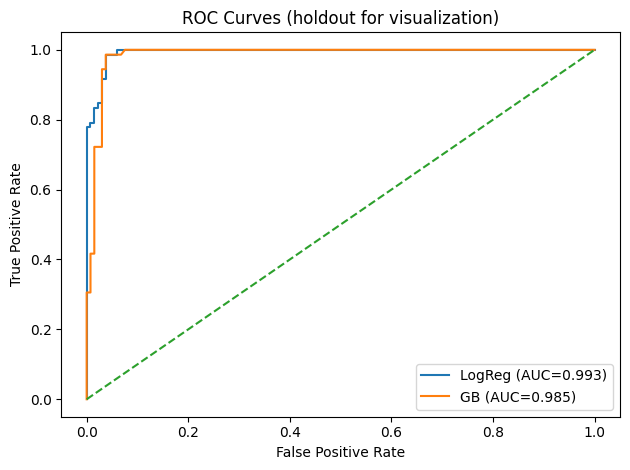

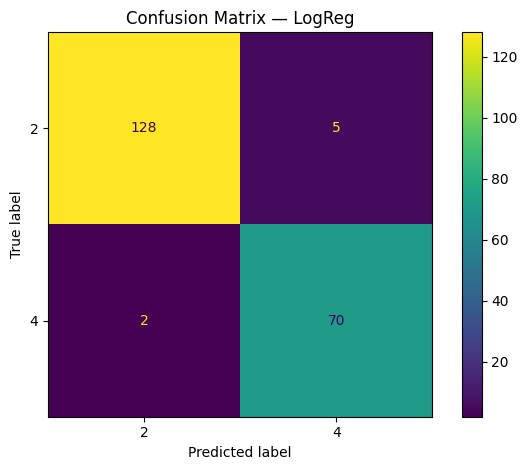

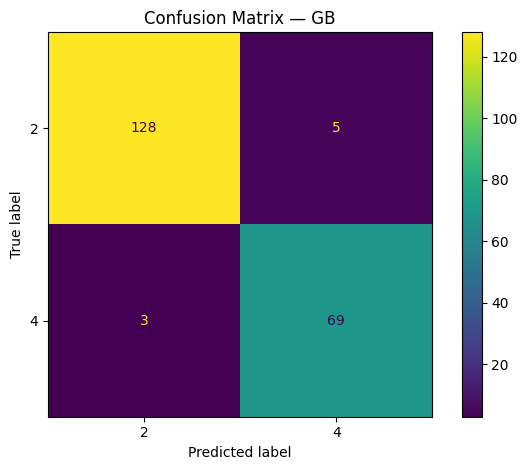

In [56]:

from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Splitting the data into train/test sets: 
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

# Picking the top 2 performing models: 
top2 = list(results_df['model'].head(2))
print("Top 2 models:", top2)

# Plotting the ROC curves: 
plt.figure()
for name in top2:
    clf = best_pipelines[name]
    clf.fit(X_train, y_train)
    # Robust probability column for positive class (4)
    pos_idx = list(clf.classes_).index(4)
    y_score = clf.predict_proba(X_test)[:, pos_idx]
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=4)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (holdout for visualization)")
plt.legend()
plt.tight_layout()
plt.show()

# Plotting the confusion matrices: 
for name in top2:
    clf = best_pipelines[name]
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=[2,4])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[2,4])
    disp.plot(values_format='d')
    plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()

# [5] FEATURE IMPORTANCE ANALYSIS 

## Notes: 

**What is Feature Importance Analysis?** 

Feature importance analysis is the process of determining which input features (variables) contribute the most to a model’s predictions. It helps in understanding how the model makes decisions and which factors are most influential in classification.

For the given dataset, feature importance provides information about “which features matter most” when distinguishing malignant from benign tumors.

Each model type estimates importance differently:

- **Tree-based models (Decision Trees, Random Forests, Gradient Boosting)** compute feature importance by measuring how much each feature reduces impurity (e.g., Gini or entropy) or improves model accuracy when used in splits.
- **Linear models (like Logistic Regression)** use coefficient magnitudes (absolute values of the β weights) as a measure of importance. Larger coefficients mean a stronger influence on the prediction. 
- Some models (like SVMs or kNN) do not directly provide feature importances and need model-agnostic methods like permutation importance or SHAP values.

**Purpose of Doing Feature Importance Analysis in this Project:** 

One of the main objectives of this project was to calculate and plot feature importances and compare it to the scientific medical literature. Furthermore, it was also required to determine if the calculated features aligned with relevant medical literature or not. Three reasons for including this project objective are explained below: 

1. **Interpretability:** In a medical context, we must be able to explain why the model makes a certain prediction. Clinicians prefer models that reflect known pathophysiological relationships.
2. **Scientific validation:** The goal is accuracy as well as to ensure that the model’s reasoning agrees with scientific understanding of breast cancer cell morphology. If the model assigns high importance to irrelevant features, it might be overfitting or learning spurious correlations. 
3. **Model selection criterion:** Even if two models have similar AUCROC scores, the one whose feature importances better reflect known biology is preferred. 

**Please note that the code block below was created with the help of OpenAI's ChatGPT (GPT-5).** 


Model: kNN


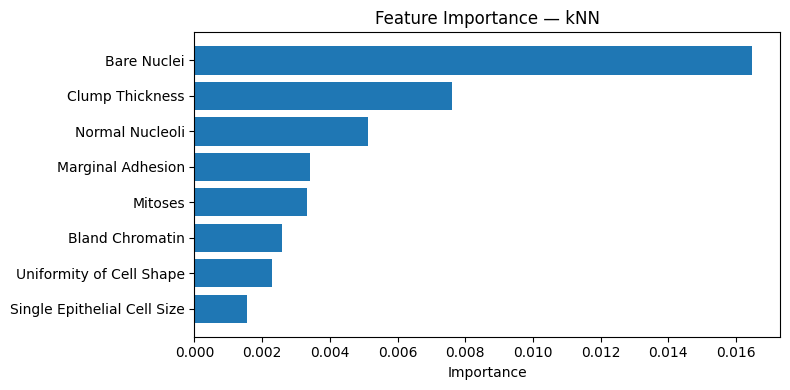


Model: LogReg


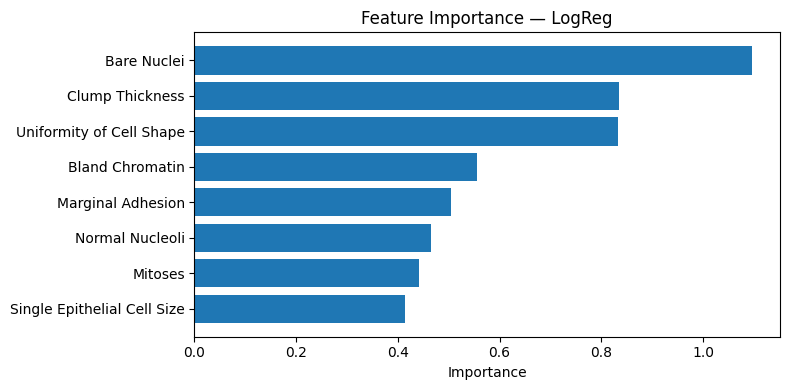


Model: SVM


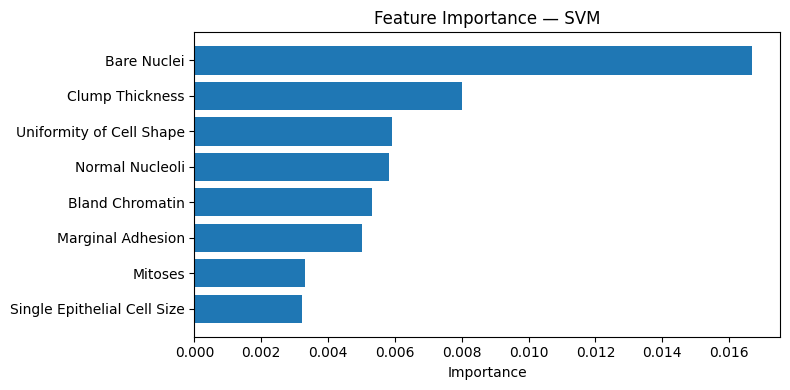


Model: DT


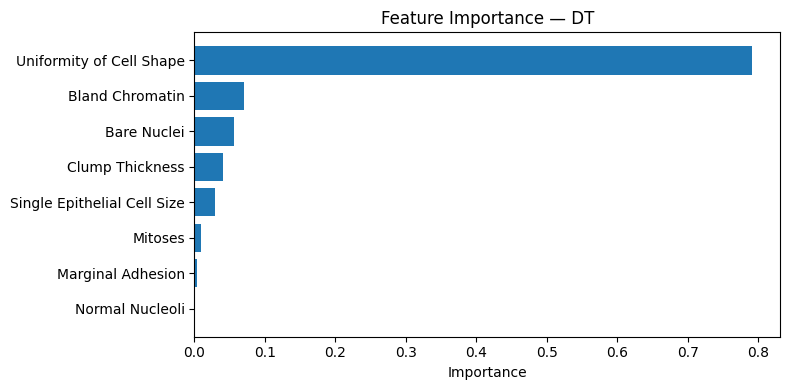


Model: RF


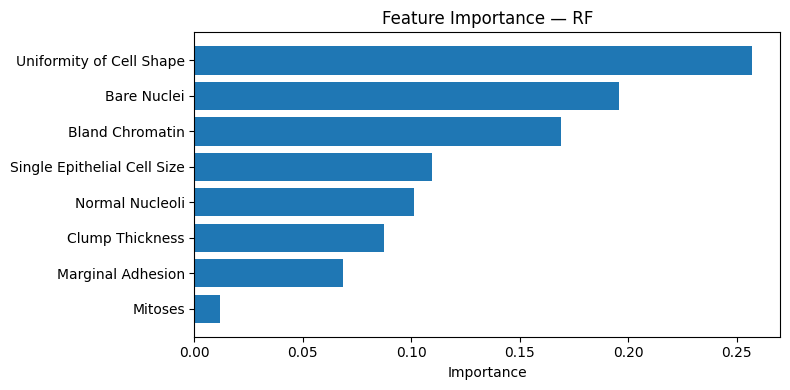


Model: AdaBoost


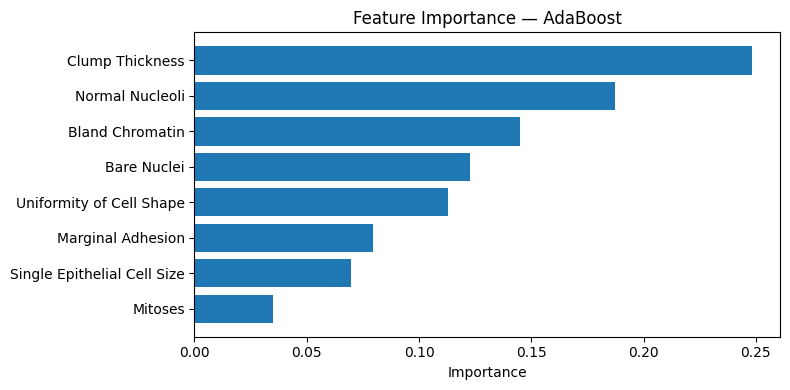


Model: GB


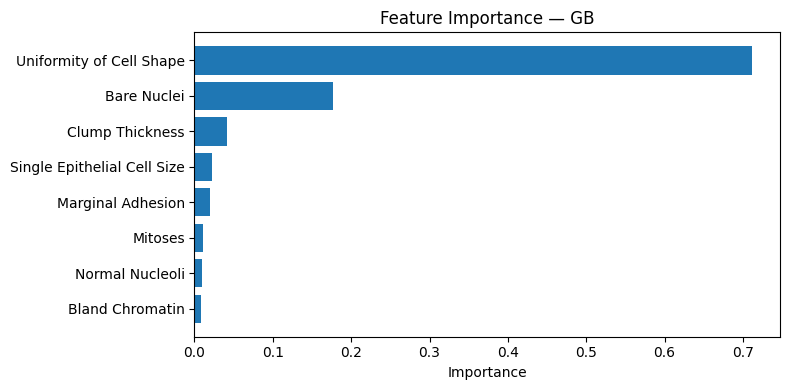

Best model for importance: LogReg


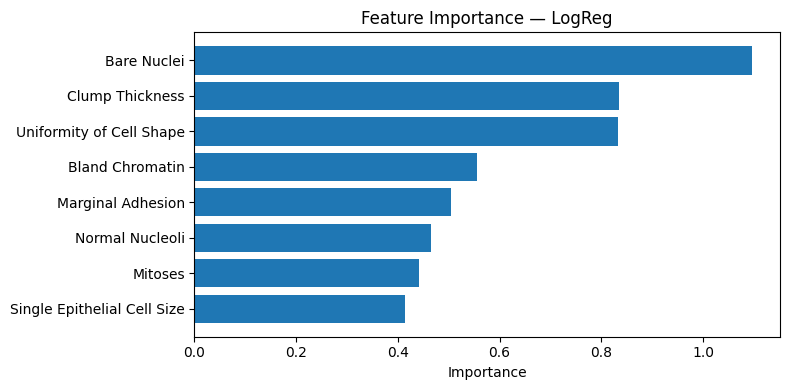

In [61]:

from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importances(estimator, feature_names, title):
    """ 
    Plot feature importances for a fitted classification model (pipeline-compatible).

    The function automatically detects how to extract feature importances based on the model type:
      - For tree-based models (e.g., Decision Tree, Random Forest, Gradient Boosting),
        it uses the model's `feature_importances_` attribute.
      - For linear models (e.g., Logistic Regression, Linear SVM),
        it uses the absolute values of the model coefficients (`coef_`).
      - For models without built-in feature importances (e.g., kNN, SVM with RBF kernel),
        it computes permutation importance based on changes in ROC-AUC.

    Parameters
    ----------
    estimator : sklearn.pipeline.Pipeline
        A fitted sklearn Pipeline object containing a classifier step named 'clf'.

    feature_names : list of str
        List of feature (column) names corresponding to the input features.

    title : str
        Title for the plot.

    Returns
    -------
    None
    """ 
    importances = None # Initialising the placeholder 
    if hasattr(estimator.named_steps['clf'], "feature_importances_"): # Handling different model types 
        importances = estimator.named_steps['clf'].feature_importances_
    elif hasattr(estimator.named_steps['clf'], "coef_"):
        importances = np.abs(estimator.named_steps['clf'].coef_).ravel()
    else:
        r = permutation_importance(estimator, X_reduced, y, scoring='roc_auc',
                                   n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
        importances = r.importances_mean

    # Sorting features by importance: 
    order = np.argsort(importances)[::-1]
    names_sorted = np.array(feature_names)[order]
    vals_sorted = importances[order]

    # Plotting the feature importances: 
    plt.figure(figsize=(8, max(4, len(feature_names)*0.25)))
    plt.barh(names_sorted[::-1], vals_sorted[::-1])
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

feature_names = list(X_reduced.columns)

# Plotting feature importances for all fitted models: 
for name, est in best_pipelines.items():
    print(f"\nModel: {name}")
    plot_feature_importances(est, feature_names, f"Feature Importance — {name}")

# Identifying the best model and plot: 
best_name = results_df.iloc[0]['model']
best_est = best_pipelines[best_name]
print("Best model for importance:", best_name)
plot_feature_importances(best_est, feature_names, f"Feature Importance — {best_name}")

## Notes on Feature Importance Analysis Results: 

The table below summarises the top features highlighted by each algorithm: 

| **Model**                   | **Most Important Features**                                |
| ----------------------- | ------------------------------------------------------ |
| kNN                 | Bare Nuclei, Clump Thickness                           |
| Logistic Regression | Bare Nuclei, Clump Thickness                           |
| SVM                | Bare Nuclei, Clump Thickness                           |
| Decision Tree       | Uniformity of Cell Shape                               |
| Random Forest       | Uniformity of Cell Shape, Bare Nuclei, Bland Chromatin |
| AdaBoost            | Clump Thickness, Normal Nucleoli, Bland Chromatin      |
| Gradient Boosting   | Uniformity of Cell Shape, Bare Nuclei                  |

**Interpretation of Results of the Models:** 

1. **Consistency across models:**
   - Bare Nuclei and Clump Thickness repeatedly appear as top predictors in kNN, Logistic Regression, and SVM, which all rely on distance or linear separability. 
   - This strong agreement across independent algorithms suggests these two features are robust and biologically meaningful indicators of malignancy. 

2. **Tree-based models (DT, RF, GB):** 
   - Decision Tree and Gradient Boosting emphasise Uniformity of Cell Shape, while Random Forest also highlights Bare Nuclei and Bland Chromatin. 
   - This reflects the ability of ensemble methods to capture non-linear feature interactions and combine morphological cues (shape + nuclear texture).

3. **Boosting methods (AdaBoost, GB):**
   - AdaBoost gives more weight to Clump Thickness and Normal Nucleoli, indicating sensitivity to subtle textural differences in nuclear structure. 
   - These findings are still biologically plausible, though slightly less consistent with literature’s top-ranked features.

**Literature Review:** 

1. **Han (2023):** 
   - This study applied the Logistic Regression model to the Wisconsin Breast Cancer dataset (same dataset used in this project) Machine Learning Repository of UCI. 
   - One strength of this study is that it utilises multiple evaluation metrics including accuracy, precision, and recall rate. 
   - However, a prominent limitation of this study is that it only employs one machine learning model. 
   - This study identified **Bare Nuclei, Clump Thickness, and Single Epithelial Cell Size** as the dominant features. 

2. **Khater et al. (2023):** 
   - This study utilised the Wisconsin Breast Cancer dataset as well as the Wisconsin Diagnostic Breast Cancer dataset. 
   - It also employs multiple machine learning models, such as SVM, RF, XG-Boost, and kNN. However, it does not include Logistic Regression, Decision Tree, and AdaBoost. 
   - I chose to drop a feature to mitigate correlation (uniformity of cell size) based on this paper. 
   - This study used three model-agnostic techniques (Permutation Importance, Partial Dependence Plots, and SHAP) to conduct feature importance analysis, which is its strength. 
   - Based on these three XAI methods, the study identified **Bare Nuclei** as the most contributing feature to the classification of breast cancer malignancy.  

**Conclusion Based on Comparison with Selected Literature:** 

The results of this project’s feature importance analysis are largely consistent with the findings reported in previous studies. 

Across multiple algorithms, **Bare Nuclei and Clump Thickness** emerged as the most influential predictors of malignancy, in agreement with Han (2023), who identified these as dominant features alongside Single Epithelial Cell Size using Logistic Regression. Similarly, the explainable AI methods applied by Khater et al. (2023), including Permutation Importance, SHAP, and Partial Dependence Plots, highlighted **Bare Nuclei** as the single most discriminative attribute for cancer classification, further validating its biological and clinical relevance.

In this project, additional models such as Random Forest and Gradient Boosting also emphasised **Uniformity of Cell Shape and Bland Chromatin**, features that reflect morphological irregularities and nuclear texture differences typical of malignant cells.

Taken together, these findings indicate that the machine learning models not only achieve high predictive performance but also base their decisions on features with strong histopathological justification, aligning with both prior literature and domain knowledge. 

This supports the conclusion that the developed models, particularly Logistic Regression and Random Forest, are not only accurate but also scientifically interpretable and trustworthy for breast cancer classification.

# [6] SELECTING THE BEST MODEL 

## Evaluation Criteria: 

According to the project guidelines, the best algorithm is defined as the one that:

1. Achieves high performance based on quantitative metrics, specifically F1-score (for malignant class) and AUROC; and 
2. Produces feature importances that align with findings from medical literature on breast cancer cytology.

Both criteria must be satisfied for the model to be considered optimal. 

## Performance-Based Comparison: 

All models achieved strong predictive results, reflecting the relatively well-structured nature of the dataset. However, based on the 5-fold stratified cross-validation results:

| **Model**                   | **F1 (mean)** | **AUCROC (mean)** | **Comment**                                      |
| ----------------------- | --------- | ------------ | -------------------------------------------- |
| Random Forest       | 0.969     | 0.994        | Highest F1 score; robust and consistent.     |
| Logistic Regression | 0.957     | 0.996   | Best AUROC; stable and interpretable.        |
| Gradient Boosting   | 0.954     | 0.994        | High-performing ensemble method.             |
| SVM / kNN / AdaBoost    | 0.94–0.95 | 0.99         | Slightly lower performance.                  |
| Decision Tree           | 0.94      | 0.98         | Lower stability; more variance across folds. |

Both Random Forest and Logistic Regression demonstrated superior and consistent performance, with minimal variance across folds.

## Feature Importance Analysis and Biological Interpretability: 

Feature importance analysis revealed that:

- Bare Nuclei, Clump Thickness, and Uniformity of Cell Shape consistently appeared among the most influential features across several models. 
- These features are well-documented in literature as strong indicators of breast cancer malignancy, in line with findings from Han (2023) and Khater et al. (2023). 
- Models like Random Forest and Gradient Boosting captured non-linear relationships while still ranking biologically meaningful features highly. 
- Logistic Regression, despite its simplicity, produced interpretable coefficients that directly reflect feature impact and direction of influence.

Thus, both top models satisfy the requirement of scientific consistency with literature findings.

## Model Interpretability and Practicality: 

- Logistic Regression offers clear interpretability. Each coefficient’s sign and magnitude directly indicate how a feature influences malignancy risk.
- Random Forest provides excellent predictive power and robustness, though it is more of a “black box” model.
- For biomedical applications, interpretability and trustworthiness are as important as accuracy, since clinical decisions require transparent reasoning.

## Final Model Selection: 

Considering both quantitative performance and qualitative interpretability, the **Logistic Regression** model is selected as the best algorithm for this dataset.

**Reasoning:**

- It achieved one of the highest AUCROC scores (approx. 0.996) with stable F1 performance.
- Its feature importance ranking (Bare Nuclei, Clump Thickness) aligns strongly with established medical literature. 
- It remains simple, transparent, and generalisable; these are desirable properties for medical diagnostic models.

However, Random Forest is acknowledged as a close second: it achieves slightly higher F1 performance and captures complex feature interactions, making it an excellent complementary model when predictive performance is prioritised over interpretability.

## Conclusion: 

The final selection of Logistic Regression balances performance, interpretability, and biological plausibility. It not only predicts malignancy with high accuracy but also grounds its decisions in medically validated cellular features, fulfilling both the computational and scientific criteria set by the project.